<h1>Chapter 5 - Text Clustering and Topic Modeling</h1>
<i>Clustering documents using a wide variety of language models.</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter05/Chapter%205%20-%20Text%20Clustering%20and%20Topic%20Modeling.ipynb)

---

This notebook is for Chapter 5 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>


### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [2]:
# %%capture
# !pip install bertopic datasets openai datamapplot

# **ArXiv Articles: Computation and Language**

In [3]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents 嵌入文档**

In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [5]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## **2. Reducing the Dimensionality of Embeddings 降低嵌入的维度**

In [6]:
from umap import UMAP # 通过导入 UMAP 类，我们可以创建 UMAP 模型对象并使用它来进行降维。

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
# n_components=5：指定降维后数据的维度。这里将输入的嵌入向量从原来的 384 维降到 5 维。
# min_dist=0.0：min_dist 控制了在低维空间中数据点之间的最小距离。值越小，数据点在低维空间中会靠得越近。设置为 0.0 表示允许数据点在低维空间中尽可能地靠近。
# metric='cosine'：指定计算数据点之间距离的度量方法。这里使用余弦相似度作为距离度量，适用于处理文本嵌入向量等具有语义信息的数据。
# random_state=42：设置随机数种子，确保每次运行代码时，UMAP 算法的结果是可重复的。
reduced_embeddings = umap_model.fit_transform(embeddings)
# fit 步骤：UMAP 模型会根据输入的 embeddings 数据学习数据的流形结构，即数据在高维空间中的分布特征。
# transform 步骤：基于学习到的流形结构，将输入的 embeddings 数据从高维空间映射到低维空间（这里是 5 维），并返回降维后的嵌入向量。

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings 对降维后的嵌入进行聚类。**

In [7]:
from hdbscan import HDBSCAN # HDBSCAN 是该库中的核心类，用于执行聚类操作。

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
# min_cluster_size=50：指定形成一个聚类所需的最小样本数量。只有当一个区域内的样本数量达到或超过 50 时，才会将其视为一个有效的聚类。
# metric='euclidean'：指定计算样本之间距离的度量方法。这里使用欧几里得距离作为距离度量，适用于处理数值型数据。
# cluster_selection_method='eom'：指定聚类选择方法。'eom' 表示使用 Excess of Mass 方法来选择聚类，该方法会根据聚类的密度和层次结构来确定最终的聚类结果。
clusters = hdbscan_model.labels_
# labels_ 是 HDBSCAN 模型对象的一个属性，它包含了每个样本所属的聚类标签。聚类标签是一个一维数组，长度为 n_samples，每个元素对应一个样本的聚类标签。
# 如果某个样本被标记为 -1，则表示该样本是噪声点，不属于任何一个聚类。

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


153

## **Inspecting the Clusters 检查聚类结果**

Manually inspect the first three documents in cluster 0:
手动检查集群0中的前三个文档：

In [8]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n") # 截取文档摘要的前 300 个字符。在截取的文本后面添加 ... 和换行符 \n，然后打印输出。

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.
接下来，我们将嵌入向量降维到二维，以便我们绘制它们并大致了解生成的聚类。

In [9]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters] # 在数据框中添加一个新的列 "cluster"，并将聚类标签 clusters 转换为字符串类型后赋值给该列。

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :] # 创建一个布尔索引，用于筛选出聚类标签不为 -1 的数据点，-1 通常表示离群点。
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(-7.778345727920533,
 10.878833436965943,
 -1.711702972650528,
 16.388065367937088)

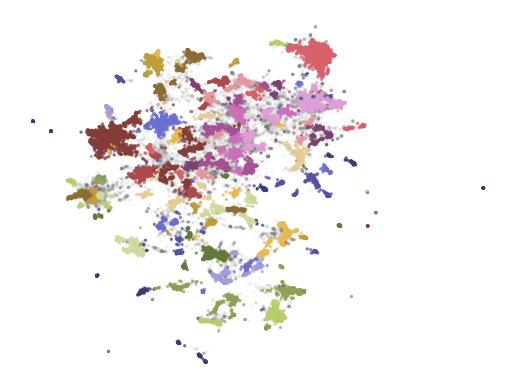

In [10]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [11]:
from bertopic import BERTopic # 用于创建和训练主题模型。

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True # 设置为 True 时，模型在训练过程中会输出详细的日志信息，方便用户了解训练的进度和状态。
).fit(abstracts, embeddings)

2025-03-07 14:53:22,851 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-07 14:54:20,814 - BERTopic - Dimensionality - Completed ✓
2025-03-07 14:54:20,817 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-07 14:54:23,931 - BERTopic - Cluster - Completed ✓
2025-03-07 14:54:23,948 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-07 14:54:28,766 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [12]:
topic_model.get_topic_info()
# opic：主题的编号。通常，编号 -1 表示离群点（即不属于任何一个明确主题的文档），其他非负整数编号对应不同的主题。
# Count：每个主题下包含的文档数量。这个数值可以反映出该主题在数据集中的相对重要性或普遍程度，数量越多，说明该主题涵盖的文档越多。
# Name：主题的名称，一般由该主题下排名靠前的几个关键词组合而成，用于概括该主题的主要内容。
# Representation：该主题的代表性文档。可以是主题下的某个具体文档，帮助用户进一步理解主题所包含的具体内容。
# Top_n_words：每个主题下排名靠前的关键词及其对应的权重。这些关键词是从主题下的文档中提取出来的，能够很好地代表该主题的核心内容。

Topic  Count                                           Name  \
0       -1  14462                               -1_the_of_and_to   
1        0   2241                 0_question_questions_qa_answer   
2        1   2098                   1_speech_asr_recognition_end   
3        2    903               2_image_visual_multimodal_images   
4        3    887  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     54           147_counseling_mental_therapy_health   
149    148     53                     148_chatgpt_its_openai_has   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51         151_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [question, questions, qa, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [image, visual, multimodal, images, vision, mo...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [counseling, mental, therapy, health, psychoth...   
149  [chatgpt, its, openai, has, it, tasks, capabil...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Cross-lingual text classification aims at t...  
1    [  Question generation (QG) attempts to solve ...  
2    [  End-to-end models have achieved impressive ...  
3    [  In this paper we propose a model to learn m...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  Mental health care poses an increasingly se...  
149  [  Over the last few years, large language mod...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  While there has been significant progress t...  

[153 rows x 5 columns]

Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:
使用默认模型生成了数百个主题！要获取每个主题的前10个关键字及其c-TF-IDF权重，我们可以使用get_topic（）函数：

In [13]:
topic_model.get_topic(0)

[('question', 0.021262463291547223),
 ('questions', 0.015866039067984204),
 ('qa', 0.015830640927795868),
 ('answer', 0.015787698152510205),
 ('answering', 0.014859992848422435),
 ('answers', 0.00992918704536005),
 ('retrieval', 0.009497931820914705),
 ('comprehension', 0.007719047154229789),
 ('reading', 0.007175282051339653),
 ('knowledge', 0.0063049421989358)]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:
我们可以使用find_topics（）函数根据搜索词搜索特定主题。让我们搜索一个关于主题建模的主题：

In [14]:
topic_model.find_topics("topic modeling")

([22, -1, 50, 38, 84],
 [0.95448655, 0.91218555, 0.9067658, 0.9051957, 0.9026561])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:
它返回主题22与我们的搜索词具有相对较高的相似度（0.95）。如果我们随后检查该主题，我们可以看到它确实是一个关于主题建模的主题：

In [15]:
topic_model.get_topic(22)

[('topic', 0.06782148231481569),
 ('topics', 0.03509097163093816),
 ('lda', 0.0162350543969945),
 ('latent', 0.013482620892138605),
 ('document', 0.01258276852968132),
 ('documents', 0.012463820004375148),
 ('modeling', 0.011571581804609226),
 ('dirichlet', 0.009901318233964887),
 ('word', 0.00852094200971816),
 ('allocation', 0.007792539607690728)]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:
这似乎是一个部分以经典LDA技术为特征的主题。让我们看看BERTopic论文是否也分配给主题22：

In [16]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

22

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".
是的！我们预计这可能是因为主题描述中存在非LDA特定的词，例如“聚类”和“主题”。

### **Visualizations**

**Visualize Documents**

In [17]:
# Visualize topics and documents
fig = topic_model.visualize_documents( # 这是 BERTopic 模型提供的一个用于可视化文档及其所属主题的方法。它会根据文档的嵌入向量和主题分配情况，生成一个交互式的可视化图形。
    titles, # 传入文档的标题列表，这些标题会在可视化图形中用于标识每个文档。
    reduced_embeddings=reduced_embeddings, # 指定文档的降维嵌入向量。这里传入降维后的嵌入向量，以便在可视化图形中准确展示文档的位置。
    width=1200, # 设置可视化图形的宽度为 1200 像素，可根据需要调整图形的大小。
    hide_annotations=True # 设置为 True 时，会隐藏可视化图形中的标注信息，使图形更加简洁。
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16)) # 将图形中所有文本元素（包括图例、坐标轴标签等）的字体大小设置为 16 像素，这样可以使图例等信息更加清晰易读。

In [18]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:
在接下来的这些示例中，我们将在训练模型后更新主题表示。这允许快速迭代。但是，如果您想在训练开始时使用表示模型，则需要按如下方式运行它：

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.
要使用表示模型，我们首先要复制我们的主题模型，以便轻松显示有表示模型和没有表示模型的模型之间的差异。

In [24]:
# Save original representations
from copy import deepcopy # deepcopy 函数用于创建对象的深拷贝。深拷贝会递归地复制对象及其所有嵌套的对象，创建一个完全独立的副本
original_topics = deepcopy(topic_model.topic_representations_)

In [23]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5]) # 使用 " | " 作为分隔符，将前 5 个关键词连接成一个字符串，存储在 og_words 变量中。
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [25]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  answering | questions | answer | question | co...  
1  phonetic | encoder | language | speech | trans...  
2  captioning | multimodal | visual | visually | ...  
3  summarization | summarizers | summaries | summ...  
4  translation | translate | translated | transla...

### Maximal Marginal Relevance

In [26]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  questions | retrieval | comprehension | knowle...  
1           speech | asr | error | model | automatic  
2      multimodal | modal | vqa | captioning | video  
3  summarization | extractive | rouge | factual |...  
4       translation | nmt | neural | bleu | parallel

## Text Generation



### Flan-T5

In [27]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 153/153 [00:13<00:00, 11.41it/s]


Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                  Updated  
0  Question answering systems |  |  |  |   
1          Speech recognition |  |  |  |   
2     Image-language learning |  |  |  |   
3               Summarization |  |  |  |   
4                Science/Tech |  |  |  |

### OpenAI

In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 156/156 [02:13<00:00,  1.17it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | he...   
2      2  sentiment | aspect | analysis | reviews | opinion   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  Leveraging External Data for Improving Low-Res...  
1  Improved Representation Learning for Biomedica...  
2  "Advancements in Aspect-Based Sentiment Analys...  
3            Neural Machine Translation Enhancements  
4                  Document Summarization Techniques

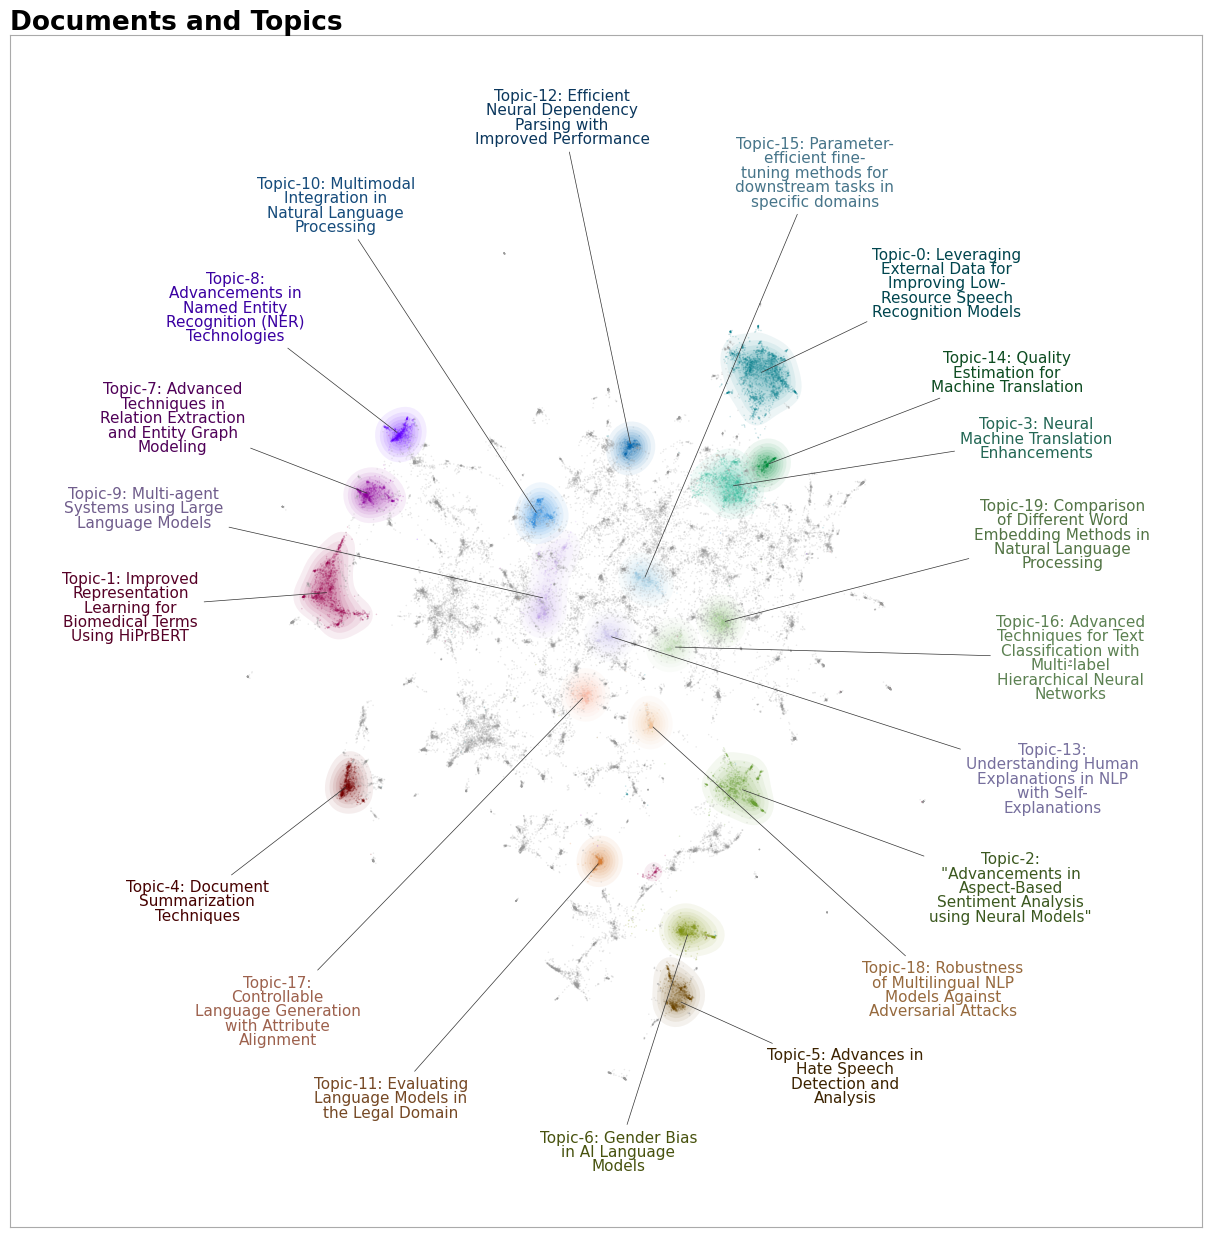

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)


## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)

Then, we can run the following code to generate the wordcloud for our topic modeling topic:

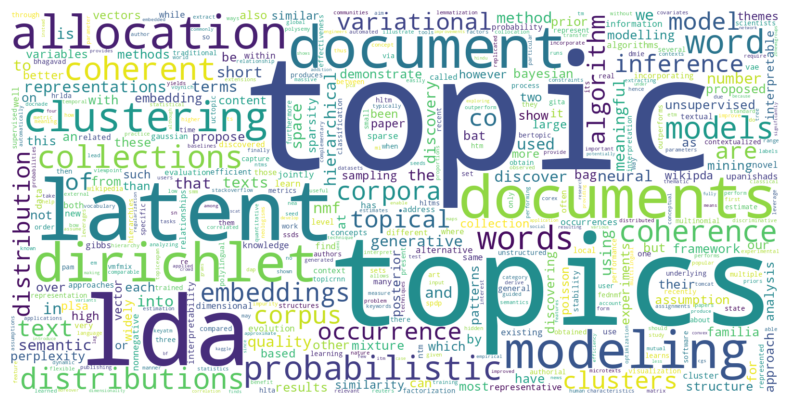

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)